In [13]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels as sm
import folium
import sys
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import ccf, ccovf
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
import warnings 
warnings.filterwarnings('ignore')

__Introduction__

Based on the visualization, it seems that the daily average temperature has similar trend with death cases in general in some states. Therefore, we may expect to add the daily temperatures into our autoregression model to see if it can improve our prediction. Besides, we notice that the death cases and confirmed cases have the same trend in general for most cases. Thus, we also try to add confirmed cases into ARIMA model with daily average temperature to see if it can improve the prediction further.

In this part, we will conduct a COVID-19 prediction under spatial (geographic region) and temporal (day) dimension for some interested states (New York, California, Florida and etc). For predicting the confirmed cases, we try a new model using daily average temperature as a potential feature. For predicting the death cases, we fit two different models, one using temperature as potential features and the other using temperature and confirmed cases as potential features. 

__Importing Data__

In [14]:
df_covid = pd.read_csv("us_daily_processed.csv")
us_state_date_confirmed = df_covid.groupby(['Province_State','date'])['Confirmed'].sum().reset_index()
us_state_date_death = df_covid.groupby(['Province_State','date'])['Deaths'].sum().reset_index()
df_confirmed_bystate = pd.DataFrame(us_state_date_confirmed)
df_death_bystate = pd.DataFrame(us_state_date_death)
df_temp= pd.read_csv("COVID_19_us_temp.csv")
df_temp= df_temp.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
df_temp_bystate=df_temp.groupby(["Province_State","date"])['Avg','Confirmed','Deaths'].sum().reset_index()
df_temp_bystate=pd.DataFrame(df_temp_bystate)
df_temp_bystate

,Province_State,date,Avg,Confirmed,Deaths
0,Arkansas,2020-02-01,46.6,0.0,0.0
1,Arkansas,2020-02-02,55.5,0.0,0.0
2,Arkansas,2020-02-03,61.0,0.0,0.0
3,Arkansas,2020-02-04,58.7,0.0,0.0
4,Arkansas,2020-02-05,40.3,0.0,0.0
...,...,...,...,...,...
5695,Wyoming,2020-05-20,65.1,787.0,11.0
5696,Wyoming,2020-05-21,56.3,801.0,12.0
5697,Wyoming,2020-05-22,60.8,803.0,12.0
5698,Wyoming,2020-05-23,57.7,813.0,12.0


In the next analysis part, we use the number of confirmed and death cases during __first 80 percents of days__ for our __training data__. And we use the number of confirmed and death cases during __last 20 percents of days__ for our __testing data__ to evaluate the model.

__Part 2. ARIMA Model Using Temperatures__

Now we will explore the time series for the temperature in each state and try to include this feature into our ARIMA models. We can not make causal statements on the relationship betwen temperatures and COVID-19 cases due to the limited data size. However, if including this feature will improve our prediction significantly, we wil use this feature.

Besides, it seems that the more confirmed cases is, the more death cases would be. Therefore, we also consider adding confirmed cases as another potential feature when we are predicting the death cases.

In particular, we analyze the COVID-19 death cases with temperature (and confirmed cases for predicting death cases) as potential feature for New York, California, Pennsylvania, Kentucky, Florida and Washington. Followings are the models we decided to use for these state

* New York: 
  
  * Confirmed Cases: ARIMA(1,1,0)
  
  * Death Cases using temperatures only: ARIMA(1,1,0)
  
  * Death Cases using temperatures and confirmed cases: ARIMA(1,1,0)

* California:
  
  * Confirmed Cases: ARIMA(3,1,0)
  
  * Death Cases using temperatures only: ARIMA(1,1,0)
  
  * Death Cases using temperatures and confirmed cases: ARIMA(1,1,0)

* Pennsylvania: 
  
  * Confirmed Cases: ARIMA(3,1,0)
  
  * Death Cases using temperatures only: ARIMA(2,1,0)
  
  * Death Cases using temperatures and confirmed cases: ARIMA(1,1,0)

* Florida:
  
  * Confirmed Cases: ARIMA(3,1,0)
  
  * Death Cases using temperatures only: ARIMA(3,1,1)
  
  * Death Cases using temperatures and confirmed cases: ARIMA(1,1,0)

* Washington:
  
  * Confirmed Cases: ARIMA(2,1,0)
  
  * Death Cases using temperatures only: ARIMA(2,1,0)
  
  * Death Cases using temperatures and confirmed cases: ARIMA(2,1,1)

Following codes are the implementation of ARIMA process with analysis part and prediction part. The analysis part contains the plot of ACF, PACF, summary table and model diagnostics. The prediction part contains the in-sample prediction, out-sample prediction.

__Remark__: After implementing the analysis, we provide a summary of our conclusion in the end of this notebook. __In the summary table of ARIMA models using confirmed cases and average temperatures, the `x1` represents the average daily temperatures and the `x2` represents the confirmed cases in that state__.

In [15]:
def select_data(state):
    df1=df_temp_bystate.loc[df_temp_bystate['Province_State'] == state]
    return df1

In [16]:
def ARIMA_with_temp(state,p1,d1,q1,p2,d2,q2,p3,d3,q3):
    ts_tot=select_data(state)
    n_sample = ts_tot.shape[0]
    n_train=int(0.8*n_sample)+1
    n_forecast=n_sample-n_train
    ts_confirmed = ts_tot['Confirmed']
    ts_deaths = ts_tot['Deaths']
    ts_tempe = ts_tot['Avg']

    ts_confirmed = pd.DataFrame(ts_confirmed)
    ts_deaths = pd.DataFrame(ts_deaths)
    ts_tempe = pd.DataFrame(ts_tempe)
    
    ts_train_c = ts_confirmed.iloc[:n_train]['Confirmed']
    ts_test_c = ts_confirmed.iloc[n_train:]['Confirmed']

    ts_train_d = ts_deaths.iloc[:n_train]['Deaths']
    ts_test_d = ts_deaths.iloc[n_train:]['Deaths']

    ts_train_t = ts_tempe.iloc[:n_train]['Avg']
    ts_test_t = ts_tempe.iloc[n_train:]['Avg']
    
    ts1=ts_tot['Avg']
    ts2=ts_tot['Confirmed']
    ts_exg = pd.concat([ts1, ts2], axis=1, sort=False)
    ts_exg_np=np.array(ts_exg)
    ts_exg_train=ts_exg_np[:n_train]
    ts_exg_test=ts_exg_np[n_train:]
    
    print("Part I. Results for Confirmed Cases in {}".format(state))
    model1=ARIMA(endog=ts_train_c,order=(p1,d1,q1),exog=ts_train_t)
    model1_fit = model1.fit(disp=0)
    predictions1 = model1_fit.forecast(steps=len(ts_test_c),exog=ts_test_t)[0]
    print(model1_fit.summary())

    residuals1 = pd.DataFrame(model1_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals1.plot(title="Residuals", ax=ax[0])
    residuals1.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    plot_acf(residuals1)
    plt.show()
    
    model1_fit.plot_predict(dynamic=False) 
    plt.title('In Sample Prediction COVID-19 Confirmed Cases in '+state)
    plt.show()
    
    ts_test_c_np=np.array(ts_test_c)
    ts_train_c_np=np.array(ts_train_c)
    
    for i in range(len(ts_test_c)):
        print('predicted=%f, expected=%f' % (int(predictions1[i]), int(ts_test_c_np[i])))
    ts_pred_c=[]
    ts_true_c=[]
    for i in range(len(ts_train_c)):
        t2=ts_train_c_np[i]
        ts_pred_c.append(int(t2))
        ts_true_c.append(int(t2))
    for i in range(len(ts_test_c)):
        t2=predictions1[i]
        ts_pred_c.append(int(t2))
        ts_true_c.append(int(ts_test_c_np[i]))
        
    plt.plot(ts_pred_c,'r',label='Predicted Cases')
    plt.plot(ts_true_c,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Confirmed Cases')
    plt.title('Out of Sample Prediction COVID-19 Confirmed Cases in '+state)
    plt.legend()
    plt.show()  
    
    print("Part II. Results for Deaths Cases in {}".format(state))
    
    model2=ARIMA(endog=ts_train_d,order=(p2,d2,q2),exog=ts_train_t)
    model2_fit = model2.fit(disp=0)
    predictions2 = model2_fit.forecast(steps=len(ts_test_d),exog=ts_test_t)[0]
    print(model2_fit.summary())

    residuals2 = pd.DataFrame(model2_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals2.plot(title="Residuals", ax=ax[0])
    residuals2.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    plot_acf(residuals2)
    plt.show()
    
    model2_fit.plot_predict(dynamic=False) 
    plt.title('In Sample Prediction COVID-19 Deaths Cases in '+state)
    plt.show()
    
    ts_test_d_np=np.array(ts_test_d)
    ts_train_d_np=np.array(ts_train_d)
    
    for i in range(len(ts_test_d)):
        print('predicted=%f, expected=%f' % (int(predictions2[i]), int(ts_test_d_np[i])))
    ts_pred_d=[]
    ts_true_d=[]
    for i in range(len(ts_train_d)):
        t2=ts_train_d_np[i]
        ts_pred_d.append(int(t2))
        ts_true_d.append(int(t2))
    for i in range(len(ts_test_d)):
        t2=predictions2[i]
        ts_pred_d.append(int(t2))
        ts_true_d.append(int(ts_test_d_np[i]))
        
    plt.plot(ts_pred_d,'r',label='Predicted Cases')
    plt.plot(ts_true_d,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Confirmed Cases')
    plt.title('Out of Sample Prediction COVID-19 Deaths Cases in '+state)
    plt.legend()
    plt.show()  
    
    print("Part III. Using Confirmed cases and temperature as features to predict death cases")
    
    model3=ARIMA(endog=ts_train_d,order=(p3,d3,q3),exog=ts_exg_train)
    model3_fit = model3.fit(disp=0)
    predictions3 = model3_fit.forecast(steps=len(ts_test_d),exog=ts_exg_test)[0]
    print(model3_fit.summary())
    
    residuals3 = pd.DataFrame(model3_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals3.plot(title="Residuals", ax=ax[0])
    residuals3.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    plot_acf(residuals3)
    plt.show()
    
    model3_fit.plot_predict(dynamic=False) 
    plt.title('In Sample Prediction COVID-19 Deaths Cases in '+state)
    plt.show()
    
    for i in range(len(ts_test_d)):
        print('predicted=%f, expected=%f' % (int(predictions3[i]), int(ts_test_d_np[i])))
    ts_pred_dc=[]
    ts_true_dc=[]
    for i in range(len(ts_train_d)):
        t2=ts_train_d_np[i]
        ts_pred_dc.append(int(t2))
        ts_true_dc.append(int(t2))
    for i in range(len(ts_test_d)):
        t2=predictions3[i]
        ts_pred_dc.append(int(t2))
        ts_true_dc.append(int(ts_test_d_np[i]))
        
    plt.plot(ts_pred_dc,'r',label='Predicted Cases')
    plt.plot(ts_true_dc,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Confirmed Cases')
    plt.title('Out of Sample Prediction COVID-19 Deaths Cases in '+state)
    plt.legend()
    plt.show()  

Part I. Results for Confirmed Cases in California
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   91
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -649.759
Method:                       css-mle   S.D. of innovations            301.418
Date:                Sun, 07 Jun 2020   AIC                           1311.519
Time:                        15:26:18   BIC                           1326.584
Sample:                             1   HQIC                          1317.596
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               525.0416    658.262      0.798      0.425    -765.127    1815.211
Avg                   2.6836      7.702      0.348      0.72

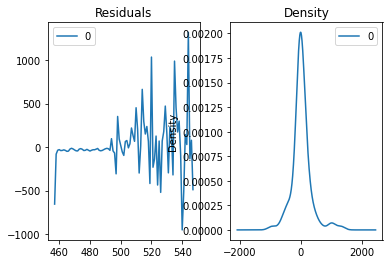

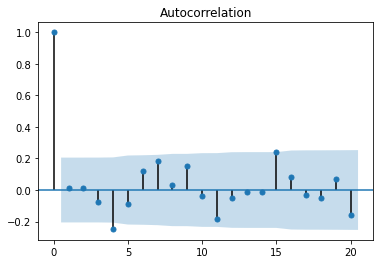

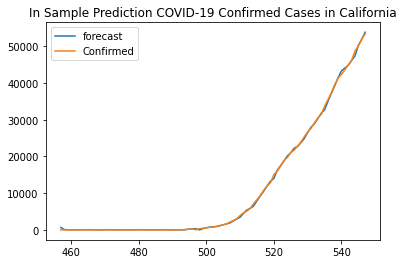

predicted=54905.000000, expected=54903.000000
predicted=56423.000000, expected=55884.000000
predicted=57873.000000, expected=58456.000000
predicted=59359.000000, expected=60616.000000
predicted=60822.000000, expected=62148.000000
predicted=62273.000000, expected=63779.000000
predicted=63707.000000, expected=66558.000000
predicted=65098.000000, expected=67600.000000
predicted=66468.000000, expected=69329.000000
predicted=67821.000000, expected=70978.000000
predicted=69155.000000, expected=72798.000000
predicted=70482.000000, expected=74871.000000
predicted=71804.000000, expected=76693.000000
predicted=73120.000000, expected=78725.000000
predicted=74412.000000, expected=80166.000000
predicted=75682.000000, expected=81457.000000
predicted=76938.000000, expected=83752.000000
predicted=78191.000000, expected=85997.000000
predicted=79445.000000, expected=88031.000000
predicted=80679.000000, expected=90252.000000
predicted=81912.000000, expected=92539.000000
predicted=83143.000000, expected=9

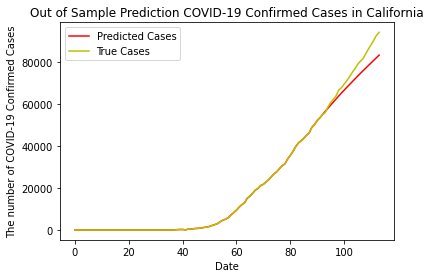

Part II. Results for Deaths Cases in California
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -380.286
Method:                       css-mle   S.D. of innovations             15.704
Date:                Sun, 07 Jun 2020   AIC                            768.573
Time:                        15:26:19   BIC                            778.616
Sample:                             1   HQIC                           772.624
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -57.0163     33.790     -1.687      0.092    -123.244       9.212
Avg                1.4569      0.585      2.490      0.013       0.310 

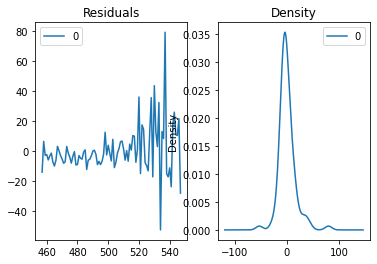

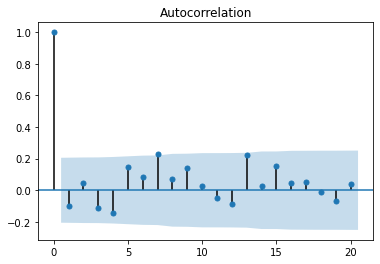

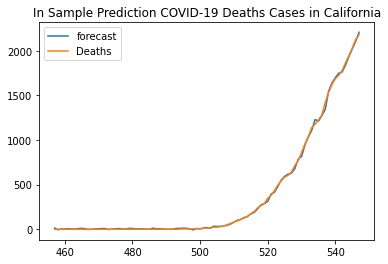

predicted=2229.000000, expected=2216.000000
predicted=2279.000000, expected=2278.000000
predicted=2331.000000, expected=2381.000000
predicted=2381.000000, expected=2464.000000
predicted=2439.000000, expected=2535.000000
predicted=2497.000000, expected=2613.000000
predicted=2551.000000, expected=2687.000000
predicted=2591.000000, expected=2716.000000
predicted=2627.000000, expected=2779.000000
predicted=2661.000000, expected=2879.000000
predicted=2693.000000, expected=2957.000000
predicted=2728.000000, expected=3052.000000
predicted=2768.000000, expected=3136.000000
predicted=2811.000000, expected=3208.000000
predicted=2849.000000, expected=3240.000000
predicted=2882.000000, expected=3279.000000
predicted=2913.000000, expected=3403.000000
predicted=2951.000000, expected=3497.000000
predicted=2995.000000, expected=3583.000000
predicted=3034.000000, expected=3666.000000
predicted=3079.000000, expected=3738.000000
predicted=3130.000000, expected=3754.000000


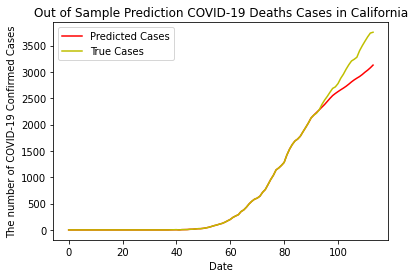

Part III. Using Confirmed cases and temperature as features to predict death cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -370.905
Method:                       css-mle   S.D. of innovations             14.233
Date:                Sun, 07 Jun 2020   AIC                            751.810
Time:                        15:26:19   BIC                            764.364
Sample:                             1   HQIC                           756.875
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -22.4464     25.683     -0.874      0.382     -72.784      27.891
x1                 0.5020      0.490

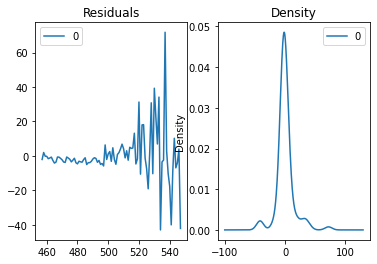

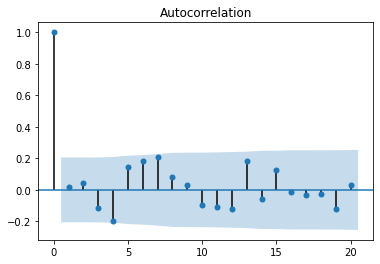

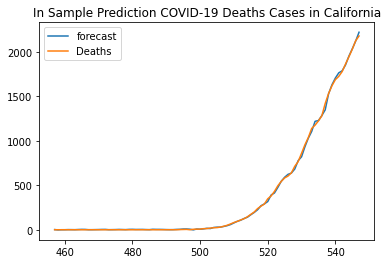

predicted=2258.000000, expected=2216.000000
predicted=2349.000000, expected=2278.000000
predicted=2451.000000, expected=2381.000000
predicted=2559.000000, expected=2464.000000
predicted=2674.000000, expected=2535.000000
predicted=2792.000000, expected=2613.000000
predicted=2913.000000, expected=2687.000000
predicted=3033.000000, expected=2716.000000
predicted=3153.000000, expected=2779.000000
predicted=3276.000000, expected=2879.000000
predicted=3402.000000, expected=2957.000000
predicted=3532.000000, expected=3052.000000
predicted=3666.000000, expected=3136.000000
predicted=3806.000000, expected=3208.000000
predicted=3945.000000, expected=3240.000000
predicted=4086.000000, expected=3279.000000
predicted=4229.000000, expected=3403.000000
predicted=4378.000000, expected=3497.000000
predicted=4533.000000, expected=3583.000000
predicted=4690.000000, expected=3666.000000
predicted=4852.000000, expected=3738.000000
predicted=5019.000000, expected=3754.000000


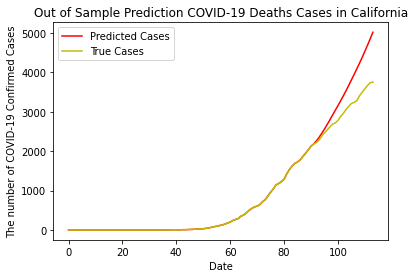

In [17]:
ARIMA_with_temp('California',3,1,0,1,1,0,1,1,0)

Part I. Results for Confirmed Cases in New York
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -799.593
Method:                       css-mle   S.D. of innovations           1568.625
Date:                Sun, 07 Jun 2020   AIC                           1607.187
Time:                        15:26:20   BIC                           1617.230
Sample:                             1   HQIC                          1611.238
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3865.1648   2215.123      1.745      0.081    -476.396    8206.726
Avg                 -12.7864     30.314     -0.422      0.673 

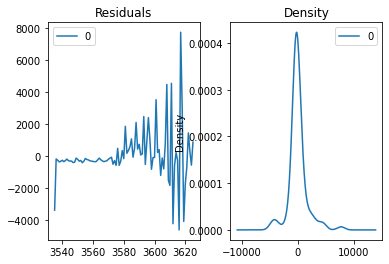

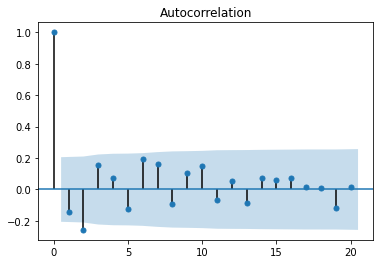

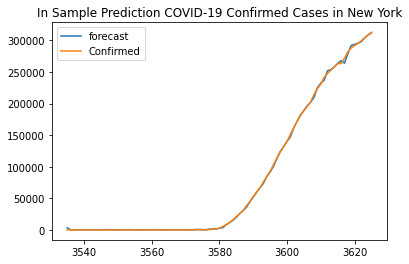

predicted=317434.000000, expected=316415.000000
predicted=321843.000000, expected=318953.000000
predicted=326234.000000, expected=321192.000000
predicted=330586.000000, expected=323978.000000
predicted=334734.000000, expected=327469.000000
predicted=338907.000000, expected=330407.000000
predicted=343095.000000, expected=333122.000000
predicted=347050.000000, expected=335395.000000
predicted=350938.000000, expected=337055.000000
predicted=354786.000000, expected=338485.000000
predicted=358575.000000, expected=340661.000000
predicted=362230.000000, expected=343051.000000
predicted=365650.000000, expected=345813.000000
predicted=369076.000000, expected=348232.000000
predicted=372591.000000, expected=350121.000000
predicted=376073.000000, expected=351371.000000
predicted=379510.000000, expected=352845.000000
predicted=382965.000000, expected=354370.000000
predicted=386405.000000, expected=356458.000000
predicted=389690.000000, expected=358154.000000
predicted=392999.000000, expected=359926

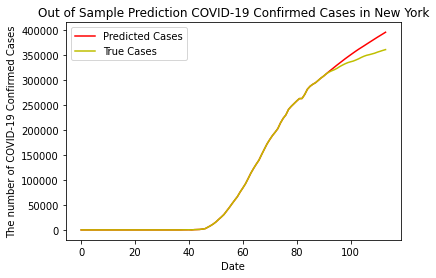

Part II. Results for Deaths Cases in New York
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -664.074
Method:                       css-mle   S.D. of innovations            356.123
Date:                Sun, 07 Jun 2020   AIC                           1336.148
Time:                        15:26:21   BIC                           1346.191
Sample:                             1   HQIC                          1340.200
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            218.3230    352.591      0.619      0.536    -472.742     909.388
Avg                0.8588      7.244      0.119      0.906     -13.339   

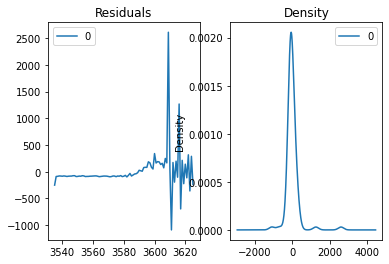

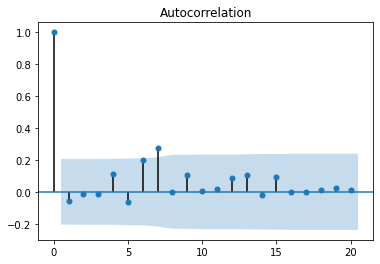

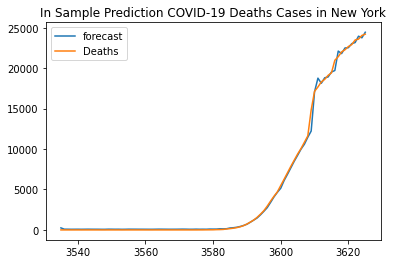

predicted=24398.000000, expected=24708.000000
predicted=24619.000000, expected=24999.000000
predicted=24850.000000, expected=25124.000000
predicted=25087.000000, expected=25623.000000
predicted=25339.000000, expected=26144.000000
predicted=25589.000000, expected=26243.000000
predicted=25836.000000, expected=26612.000000
predicted=26096.000000, expected=26641.000000
predicted=26357.000000, expected=26988.000000
predicted=26618.000000, expected=27284.000000
predicted=26879.000000, expected=27477.000000
predicted=27147.000000, expected=27641.000000
predicted=27428.000000, expected=27878.000000
predicted=27705.000000, expected=28049.000000
predicted=27975.000000, expected=28232.000000
predicted=28244.000000, expected=28339.000000
predicted=28513.000000, expected=28558.000000
predicted=28780.000000, expected=28636.000000
predicted=29046.000000, expected=28743.000000
predicted=29321.000000, expected=28853.000000
predicted=29593.000000, expected=29031.000000
predicted=29862.000000, expected=2

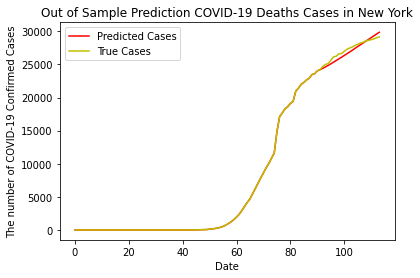

Part III. Using Confirmed cases and temperature as features to predict death cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -659.162
Method:                       css-mle   S.D. of innovations            338.012
Date:                Sun, 07 Jun 2020   AIC                           1328.324
Time:                        15:26:22   BIC                           1340.878
Sample:                             1   HQIC                          1333.389
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            229.3805    308.284      0.744      0.457    -374.845     833.605
x1                -4.0520      6.818

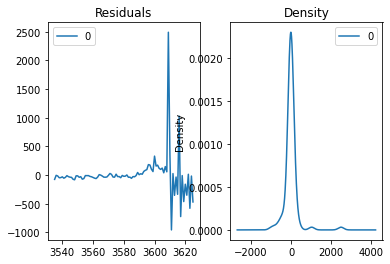

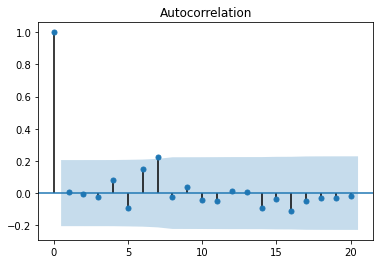

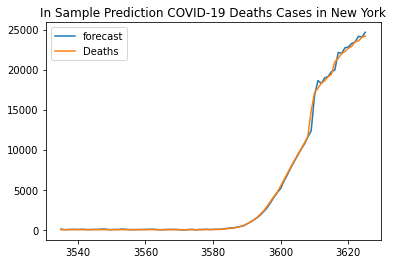

predicted=24674.000000, expected=24708.000000
predicted=25345.000000, expected=24999.000000
predicted=26133.000000, expected=25124.000000
predicted=26989.000000, expected=25623.000000
predicted=27839.000000, expected=26144.000000
predicted=28742.000000, expected=26243.000000
predicted=29688.000000, expected=26612.000000
predicted=30592.000000, expected=26641.000000
predicted=31502.000000, expected=26988.000000
predicted=32423.000000, expected=27284.000000
predicted=33349.000000, expected=27477.000000
predicted=34256.000000, expected=27641.000000
predicted=35110.000000, expected=27878.000000
predicted=35987.000000, expected=28049.000000
predicted=36909.000000, expected=28232.000000
predicted=37835.000000, expected=28339.000000
predicted=38762.000000, expected=28558.000000
predicted=39707.000000, expected=28636.000000
predicted=40662.000000, expected=28743.000000
predicted=41581.000000, expected=28853.000000
predicted=42518.000000, expected=29031.000000
predicted=43471.000000, expected=2

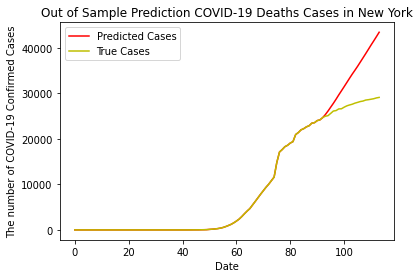

In [18]:
ARIMA_with_temp('New York',1,1,0,1,1,0,1,1,0)

Part I. Results for Confirmed Cases in Pennsylvania
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   91
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -631.156
Method:                       css-mle   S.D. of innovations            245.698
Date:                Sun, 07 Jun 2020   AIC                           1274.313
Time:                        15:26:24   BIC                           1289.378
Sample:                             1   HQIC                          1280.391
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               640.1064    505.223      1.267      0.205    -350.113    1630.326
Avg                  -1.1946      4.139     -0.289      0.

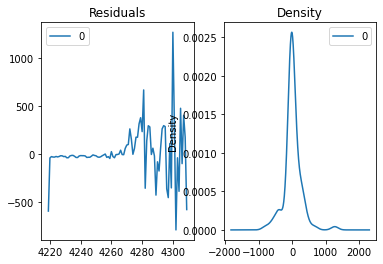

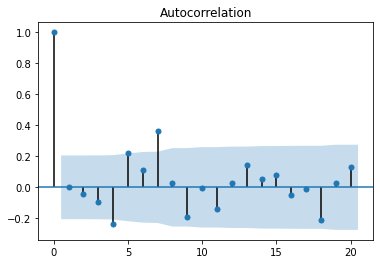

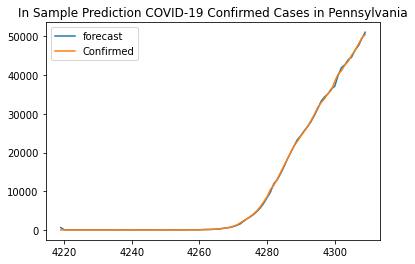

predicted=51767.000000, expected=51225.000000
predicted=52957.000000, expected=52816.000000
predicted=54110.000000, expected=53864.000000
predicted=55287.000000, expected=54800.000000
predicted=56432.000000, expected=55956.000000
predicted=57572.000000, expected=57371.000000
predicted=58711.000000, expected=58560.000000
predicted=59824.000000, expected=59939.000000
predicted=60925.000000, expected=60459.000000
predicted=62013.000000, expected=61310.000000
predicted=63087.000000, expected=62101.000000
predicted=64145.000000, expected=63105.000000
predicted=65172.000000, expected=64136.000000
predicted=66196.000000, expected=65185.000000
predicted=67215.000000, expected=65700.000000
predicted=68223.000000, expected=66669.000000
predicted=69224.000000, expected=67311.000000
predicted=70219.000000, expected=68126.000000
predicted=71202.000000, expected=69252.000000
predicted=72168.000000, expected=70211.000000
predicted=73121.000000, expected=71009.000000
predicted=74071.000000, expected=7

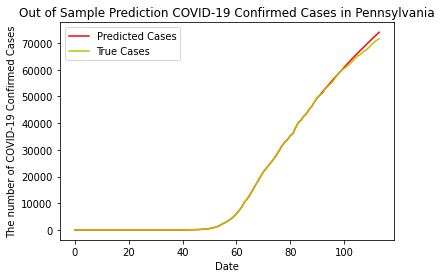

Part II. Results for Deaths Cases in Pennsylvania
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -469.241
Method:                       css-mle   S.D. of innovations             41.806
Date:                Sun, 07 Jun 2020   AIC                            948.482
Time:                        15:26:25   BIC                            961.037
Sample:                             1   HQIC                           953.547
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.8405     38.509      0.204      0.839     -67.635      83.316
Avg                0.5074      0.734      0.691      0.489      -0.93

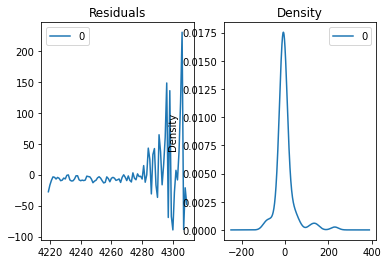

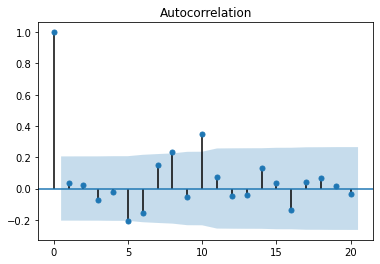

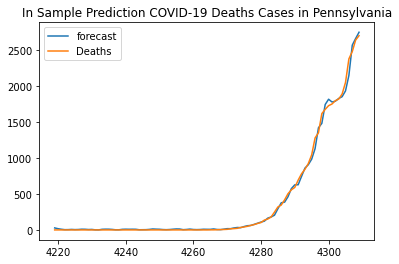

predicted=2794.000000, expected=2720.000000
predicted=2863.000000, expected=2838.000000
predicted=2931.000000, expected=3179.000000
predicted=2988.000000, expected=3345.000000
predicted=3046.000000, expected=3589.000000
predicted=3096.000000, expected=3715.000000
predicted=3139.000000, expected=3779.000000
predicted=3185.000000, expected=3806.000000
predicted=3229.000000, expected=3832.000000
predicted=3272.000000, expected=3914.000000
predicted=3315.000000, expected=4094.000000
predicted=3358.000000, expected=4288.000000
predicted=3408.000000, expected=4422.000000
predicted=3455.000000, expected=4480.000000
predicted=3498.000000, expected=4495.000000
predicted=3541.000000, expected=4515.000000
predicted=3582.000000, expected=4628.000000
predicted=3621.000000, expected=4770.000000
predicted=3661.000000, expected=4869.000000
predicted=3703.000000, expected=5010.000000
predicted=3747.000000, expected=5112.000000
predicted=3788.000000, expected=5136.000000


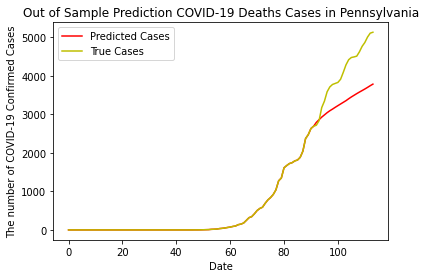

Part III. Using Confirmed cases and temperature as features to predict death cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -460.653
Method:                       css-mle   S.D. of innovations             38.212
Date:                Sun, 07 Jun 2020   AIC                            931.305
Time:                        15:26:26   BIC                            943.859
Sample:                             1   HQIC                           936.370
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.0427     27.972     -0.109      0.913     -57.867      51.782
x1                 0.0812      0.626

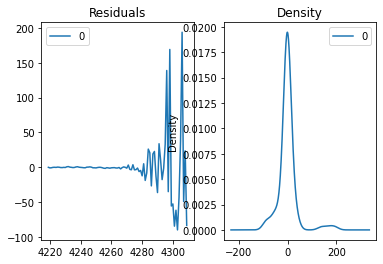

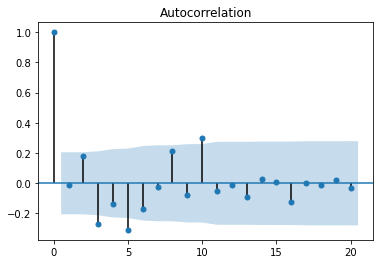

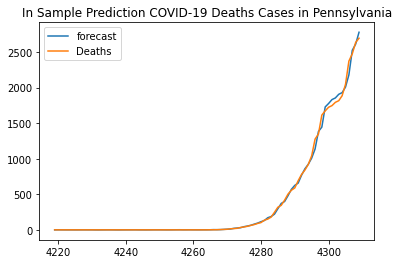

predicted=2832.000000, expected=2720.000000
predicted=2980.000000, expected=2838.000000
predicted=3130.000000, expected=3179.000000
predicted=3283.000000, expected=3345.000000
predicted=3440.000000, expected=3589.000000
predicted=3600.000000, expected=3715.000000
predicted=3762.000000, expected=3779.000000
predicted=3930.000000, expected=3806.000000
predicted=4098.000000, expected=3832.000000
predicted=4269.000000, expected=3914.000000
predicted=4443.000000, expected=4094.000000
predicted=4620.000000, expected=4288.000000
predicted=4800.000000, expected=4422.000000
predicted=4984.000000, expected=4480.000000
predicted=5168.000000, expected=4495.000000
predicted=5355.000000, expected=4515.000000
predicted=5543.000000, expected=4628.000000
predicted=5734.000000, expected=4770.000000
predicted=5928.000000, expected=4869.000000
predicted=6125.000000, expected=5010.000000
predicted=6324.000000, expected=5112.000000
predicted=6525.000000, expected=5136.000000


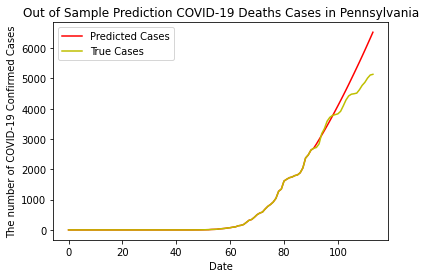

In [19]:
ARIMA_with_temp('Pennsylvania',3,1,0,2,1,0,1,1,0)

Part I. Results for Confirmed Cases in Florida
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   91
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -633.721
Method:                       css-mle   S.D. of innovations            253.303
Date:                Sun, 07 Jun 2020   AIC                           1279.442
Time:                        15:26:27   BIC                           1294.508
Sample:                             1   HQIC                          1285.520
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               507.6308    348.436      1.457      0.145    -175.291    1190.553
Avg                  -1.8097      3.290     -0.550      0.582  

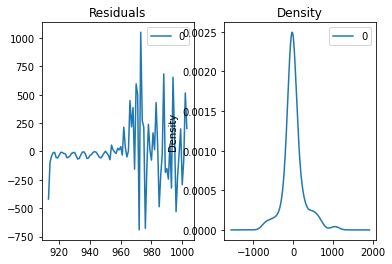

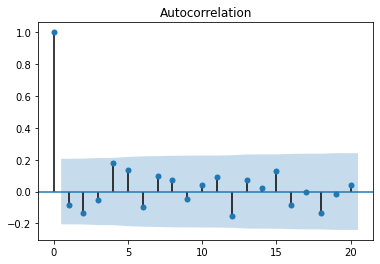

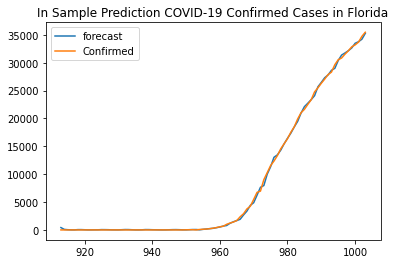

predicted=36181.000000, expected=36078.000000
predicted=36999.000000, expected=36897.000000
predicted=37712.000000, expected=37439.000000
predicted=38432.000000, expected=38002.000000
predicted=39178.000000, expected=38828.000000
predicted=39886.000000, expected=39199.000000
predicted=40585.000000, expected=40001.000000
predicted=41272.000000, expected=40596.000000
predicted=41943.000000, expected=40982.000000
predicted=42609.000000, expected=41923.000000
predicted=43257.000000, expected=42402.000000
predicted=43891.000000, expected=43210.000000
predicted=44514.000000, expected=44138.000000
predicted=45125.000000, expected=44811.000000
predicted=45726.000000, expected=45588.000000
predicted=46327.000000, expected=46442.000000
predicted=46914.000000, expected=46944.000000
predicted=47506.000000, expected=47471.000000
predicted=48084.000000, expected=48675.000000
predicted=48651.000000, expected=49451.000000
predicted=49211.000000, expected=50127.000000
predicted=49761.000000, expected=5

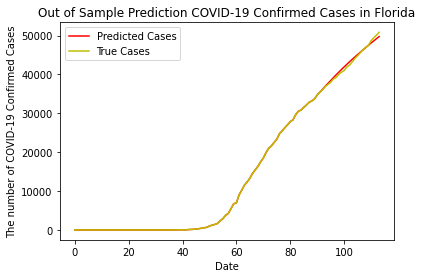

Part II. Results for Deaths Cases in Florida
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -382.709
Method:                       css-mle   S.D. of innovations             14.721
Date:                Sun, 07 Jun 2020   AIC                            779.417
Time:                        15:26:28   BIC                            796.993
Sample:                             1   HQIC                           786.508
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -43.3693     62.013     -0.699      0.484    -164.913      78.174
Avg               -0.1502      0.215     -0.699      0.484      -0.571    

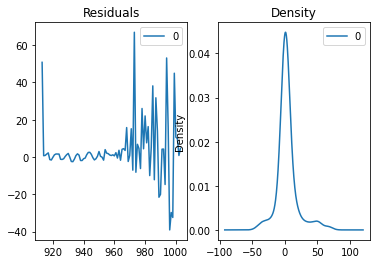

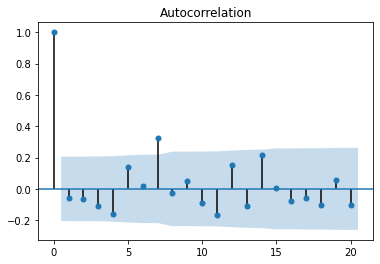

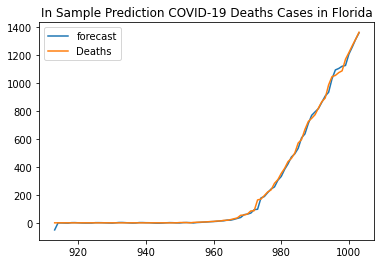

predicted=1409.000000, expected=1379.000000
predicted=1456.000000, expected=1399.000000
predicted=1502.000000, expected=1471.000000
predicted=1547.000000, expected=1539.000000
predicted=1595.000000, expected=1600.000000
predicted=1642.000000, expected=1669.000000
predicted=1689.000000, expected=1715.000000
predicted=1735.000000, expected=1721.000000
predicted=1781.000000, expected=1735.000000
predicted=1827.000000, expected=1779.000000
predicted=1873.000000, expected=1827.000000
predicted=1919.000000, expected=1875.000000
predicted=1964.000000, expected=1917.000000
predicted=2009.000000, expected=1964.000000
predicted=2054.000000, expected=1973.000000
predicted=2099.000000, expected=1997.000000
predicted=2145.000000, expected=2052.000000
predicted=2191.000000, expected=2096.000000
predicted=2236.000000, expected=2144.000000
predicted=2281.000000, expected=2190.000000
predicted=2327.000000, expected=2233.000000
predicted=2372.000000, expected=2237.000000


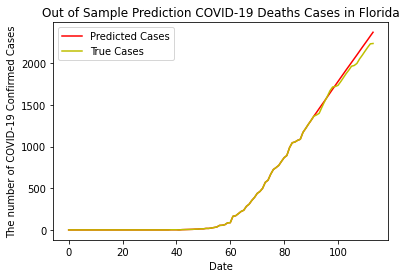

Part III. Using Confirmed cases and temperature as features to predict death cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -367.264
Method:                       css-mle   S.D. of innovations             13.693
Date:                Sun, 07 Jun 2020   AIC                            744.528
Time:                        15:26:29   BIC                            757.082
Sample:                             1   HQIC                           749.592
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.9904     11.424     -0.262      0.794     -25.382      19.401
x1                 0.0765      0.180

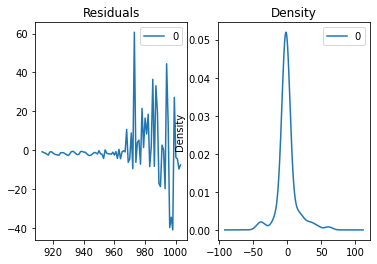

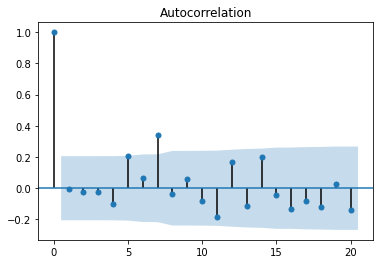

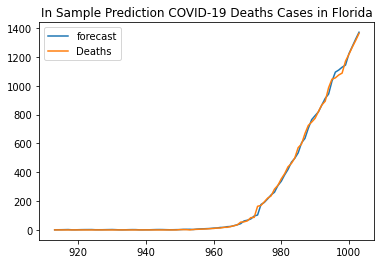

predicted=1422.000000, expected=1379.000000
predicted=1481.000000, expected=1399.000000
predicted=1541.000000, expected=1471.000000
predicted=1602.000000, expected=1539.000000
predicted=1663.000000, expected=1600.000000
predicted=1725.000000, expected=1669.000000
predicted=1789.000000, expected=1715.000000
predicted=1854.000000, expected=1721.000000
predicted=1919.000000, expected=1735.000000
predicted=1986.000000, expected=1779.000000
predicted=2054.000000, expected=1827.000000
predicted=2123.000000, expected=1875.000000
predicted=2193.000000, expected=1917.000000
predicted=2265.000000, expected=1964.000000
predicted=2338.000000, expected=1973.000000
predicted=2412.000000, expected=1997.000000
predicted=2487.000000, expected=2052.000000
predicted=2563.000000, expected=2096.000000
predicted=2640.000000, expected=2144.000000
predicted=2719.000000, expected=2190.000000
predicted=2799.000000, expected=2233.000000
predicted=2880.000000, expected=2237.000000


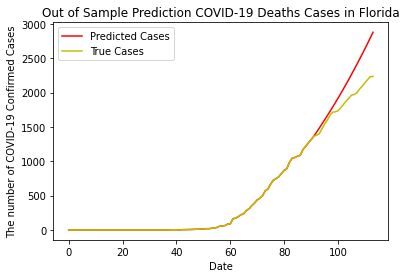

In [20]:
ARIMA_with_temp('Florida',3,1,0,3,1,1,1,1,0)

Part I. Results for Confirmed Cases in Washington
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   91
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -586.928
Method:                       css-mle   S.D. of innovations            152.351
Date:                Sun, 07 Jun 2020   AIC                           1183.857
Time:                        15:26:30   BIC                           1196.411
Sample:                             1   HQIC                          1188.922
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -94.1968    235.689     -0.400      0.689    -556.139     367.745
Avg                   5.5829      4.915      1.136      0.25

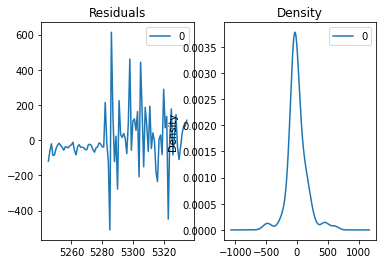

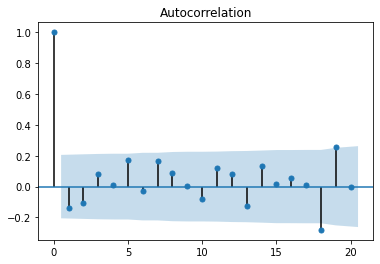

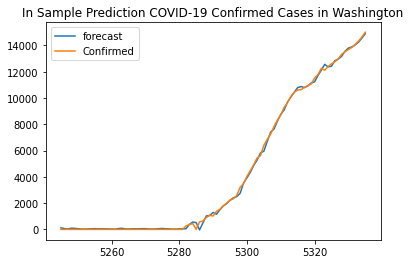

predicted=15266.000000, expected=15185.000000
predicted=15573.000000, expected=15462.000000
predicted=15875.000000, expected=15594.000000
predicted=16148.000000, expected=15905.000000
predicted=16417.000000, expected=16231.000000
predicted=16742.000000, expected=16388.000000
predicted=17098.000000, expected=16674.000000
predicted=17463.000000, expected=16891.000000
predicted=17734.000000, expected=17122.000000
predicted=17974.000000, expected=17330.000000
predicted=18210.000000, expected=17512.000000
predicted=18443.000000, expected=17773.000000
predicted=18687.000000, expected=17951.000000
predicted=18924.000000, expected=18288.000000
predicted=19160.000000, expected=18433.000000
predicted=19400.000000, expected=18611.000000
predicted=19625.000000, expected=18811.000000
predicted=19835.000000, expected=18971.000000
predicted=20030.000000, expected=19117.000000
predicted=20234.000000, expected=19265.000000
predicted=20449.000000, expected=19265.000000
predicted=20690.000000, expected=1

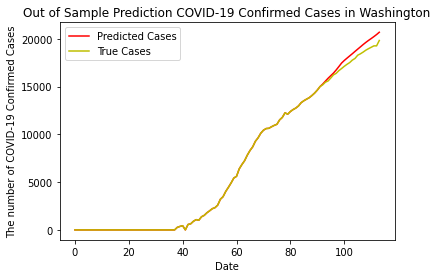

Part II. Results for Deaths Cases in Washington
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -329.088
Method:                       css-mle   S.D. of innovations              8.980
Date:                Sun, 07 Jun 2020   AIC                            668.177
Time:                        15:26:31   BIC                            680.731
Sample:                             1   HQIC                           673.242
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -25.6109     13.343     -1.919      0.055     -51.762       0.541
Avg                0.7408      0.284      2.611      0.009       0.185 

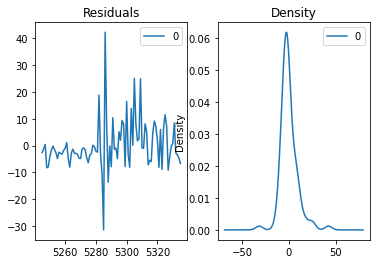

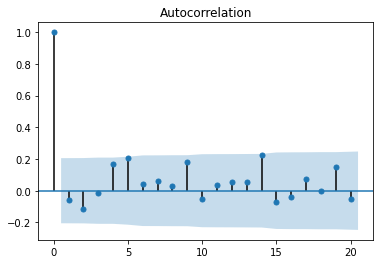

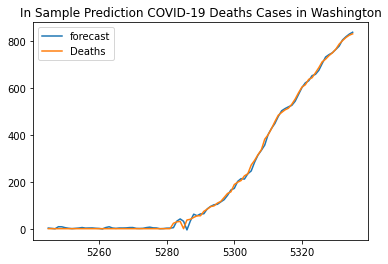

predicted=837.000000, expected=834.000000
predicted=847.000000, expected=841.000000
predicted=863.000000, expected=862.000000
predicted=876.000000, expected=870.000000
predicted=890.000000, expected=891.000000
predicted=913.000000, expected=905.000000
predicted=942.000000, expected=921.000000
predicted=973.000000, expected=931.000000
predicted=992.000000, expected=945.000000
predicted=1008.000000, expected=962.000000
predicted=1024.000000, expected=974.000000
predicted=1040.000000, expected=983.000000
predicted=1057.000000, expected=991.000000
predicted=1074.000000, expected=999.000000
predicted=1091.000000, expected=1001.000000
predicted=1109.000000, expected=1002.000000
predicted=1125.000000, expected=1031.000000
predicted=1139.000000, expected=1037.000000
predicted=1151.000000, expected=1044.000000
predicted=1164.000000, expected=1050.000000
predicted=1179.000000, expected=1050.000000
predicted=1198.000000, expected=1061.000000


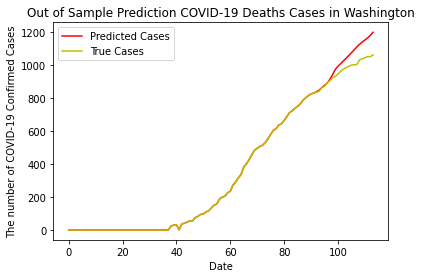

Part III. Using Confirmed cases and temperature as features to predict death cases
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                   91
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -322.766
Method:                       css-mle   S.D. of innovations              8.367
Date:                Sun, 07 Jun 2020   AIC                            659.531
Time:                        15:26:32   BIC                            677.107
Sample:                             1   HQIC                           666.622
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -9.0154     12.047     -0.748      0.454     -32.627      14.596
x1                 0.2857      0.269

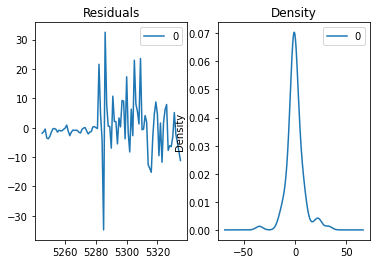

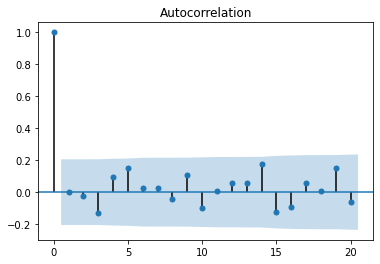

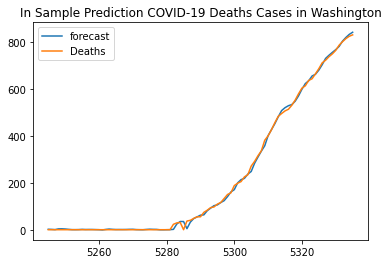

predicted=844.000000, expected=834.000000
predicted=858.000000, expected=841.000000
predicted=875.000000, expected=862.000000
predicted=890.000000, expected=870.000000
predicted=907.000000, expected=891.000000
predicted=927.000000, expected=905.000000
predicted=950.000000, expected=921.000000
predicted=973.000000, expected=931.000000
predicted=992.000000, expected=945.000000
predicted=1011.000000, expected=962.000000
predicted=1029.000000, expected=974.000000
predicted=1048.000000, expected=983.000000
predicted=1068.000000, expected=991.000000
predicted=1088.000000, expected=999.000000
predicted=1108.000000, expected=1001.000000
predicted=1129.000000, expected=1002.000000
predicted=1149.000000, expected=1031.000000
predicted=1169.000000, expected=1037.000000
predicted=1188.000000, expected=1044.000000
predicted=1208.000000, expected=1050.000000
predicted=1229.000000, expected=1050.000000
predicted=1251.000000, expected=1061.000000


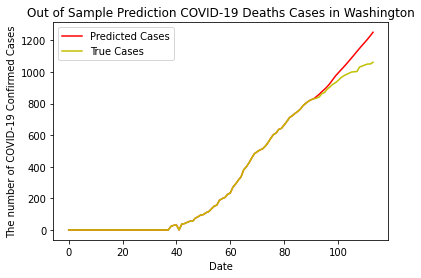

In [21]:
ARIMA_with_temp('Washington',2,1,0,2,1,0,2,1,1)

### Conclusion and Summary

1. When we are predicting the confirmed cases, the prediction seems to be __worse__ when we include temperature in ARIMA model for predicting the confirmed cases in __Washington__. And there seems to be __no big difference__ between new model and previous model for __rest other states__. Therefore, when we are predicting the confirmed cases, we do not need to include the average daily temperature in our model. 

2. When we are predicting the death cases, there seems to be __no big difference__ between new model and previous model for __New York__, __Washington__. There seems to be __some slight improvement__ when we include temperature in the model for predicting the confirmed cases in __California__ and __Pennsylvania__. And the prediction seems to be __much better__ when we include temperature in ARIMA model for predicting the death cases in __Florida__.

3. Only in some states, the temperature is a significant factor for predicting death cases, for example __California__ and __Washington__. This makes sense, because for confirmed cases, it mainly depends on the social distances and frequency of group activities. However, for death cases, the temperature will inflence some virus activity under specific conditions, which in turn will affect the death cases.

4. Based on the summary table, we see that the coefficient for average temperature is __positive__. Therefore, we may expect a __larger number of death cases__ when the __temperature is relatively high__.

5. When we are predicting death cases, it is not good to use confirmed cases as a feature. Temperature is enough. Although the confirmed cases is a highly significant factor, it will cause the overfitting for the model and make the out-sample prediction even worse.